In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [17]:

from FRVRS import nu
import os.path as osp
import re
import os
import pandas as pd
import networkx as nx
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt


# Analyze Util Function Usage Frequency

In [4]:

nu.delete_ipynb_checkpoint_folders()


## Create a within-function function-call node-and-edge network visualization

In [18]:

# Create a regular expression of all the utils function definitions
# Assumes there are no double quotes inside of docstrings
defs_regex = re.compile(r'^    def ([a-z]+[a-z_]+)\([^\)]+\):\s+"""[^"]+"""', re.MULTILINE)

# Get a list of all the functions in each module
get_module_prefix = lambda file_name: ''.join([s[0] for s in file_name.split('.')[0].split('_')])
functions_dict = {}
for file_name in ['frvrs_utils.py', 'notebook_utils.py']:
    with open(f'../py/FRVRS/{file_name}', 'r', encoding=nu.encoding_type) as f:
        text = f.read()
        functions_list = []
        defs_list = defs_regex.split(text)
        for fn_name in [defs_list[i] for i in range(1, len(defs_list), 2)]: functions_list.append(fn_name)
        functions_dict[get_module_prefix(file_name)] = functions_list

# Create data structures to tally the nodes, edges, and weights
nodes_set = set()
edge_tuple_dict = {}
for file_name in ['frvrs_utils.py', 'notebook_utils.py']:
    with open(f'../py/FRVRS/{file_name}', 'r', encoding=nu.encoding_type) as f:
        module_prefix = get_module_prefix(file_name)
        
        # Create a regular expression of all the utils function self-calls
        functions_str = '|'.join(functions_dict[module_prefix])
        right_str = f'\\bself\\.(?:{functions_str})'
        
        # Create a regular expression of all the calls from the other module
        other_prefix = module_prefix.replace('f', 'x').replace('n', 'f').replace('x', 'n')
        functions_str = '|'.join(functions_dict[other_prefix])
        left_str = f'\\b{other_prefix}\\.(?:{functions_str})'
        
        # Create a regular expression of both kinds of utils function calls
        all_calls_regex = re.compile(f'{left_str}|{right_str}')
        
        text = f.read()
        defs_list = defs_regex.split(text)
        for fn_name, fn_body in zip([defs_list[i] for i in range(1, len(defs_list), 2)], [defs_list[i] for i in range(2, len(defs_list), 2)]):
            fn_name = module_prefix + '.' + fn_name
            calls_list = all_calls_regex.findall(fn_body)
            if calls_list:
                nodes_set.add(fn_name)
                for called in calls_list:
                    called = called.replace('self.', module_prefix + '.')
                    nodes_set.add(called)
                    edge_tuple = (called, fn_name)
                    edge_tuple_dict[edge_tuple] = edge_tuple_dict.get(edge_tuple, 0) + 1

# Create the directed graph
dg = nx.DiGraph()
dg.add_nodes_from(nodes_set)
dg.add_weighted_edges_from([(k[0], k[1], v) for k, v in edge_tuple_dict.items()])

In [6]:

def show_subgraph(sub_graph, suptitle='Within-function Function Calls', nodes_list_list=None, verbose=False):
    
    # Vertically separate the labels for easier readability
    layout_items = nx.spring_layout(sub_graph).items()
    left_lim, right_lim = -1500, 1500
    bottom_lim, top_lim = left_lim * nu.twitter_aspect_ratio, right_lim * nu.twitter_aspect_ratio
    rows_list = [{'node_name': node_name, 'layout_x': pos_array[0], 'layout_y': pos_array[1]} for node_name, pos_array in layout_items]
    df = DataFrame(rows_list).sort_values('layout_x')
    df['x_tick'] = [int(round(el)) for el in pd.cut(np.array([left_lim, right_lim]), len(sub_graph.nodes)+1, retbins=True)[1]][1:-1]
    df = df.sort_values('layout_y')
    df['y_tick'] = [int(round(el)) for el in pd.cut(np.array([bottom_lim, top_lim]), len(sub_graph.nodes)+1, retbins=True)[1]][1:-1]
    
    # Create the layout dictionary
    layout_dict = {}
    for row_index, row_series in df.iterrows():
        node_name = row_series.node_name
        layout_x = row_series.x_tick
        layout_y = row_series.y_tick
        layout_dict[node_name] = np.array([float(layout_x), float(layout_y)])
    
    # Draw the graph using the layout
    fig = plt.figure(figsize=(18, 7))
    ax = fig.add_subplot(111)
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.suptitle(suptitle, fontsize=24)
    
    # Make the nodes blue
    if nodes_list_list is None: node_collection = nx.draw_networkx_nodes(G=sub_graph, pos=layout_dict, alpha=0.25, node_color='b', node_size=150)
    
    # Color each nodes list differently
    else:
        color_cycler = nu.get_color_cycler(len(nodes_list_list))
        for nodes_list, fcd in zip(nodes_list_list, color_cycler()):
            if verbose: display(fcd['color'])
            node_color = fcd['color'].reshape(1, -1)
            node_collection = nx.draw_networkx_nodes(G=nx.subgraph(sub_graph, nodes_list), pos=layout_dict, alpha=0.25, node_color=node_color, node_size=150)
    
    edge_collection = nx.draw_networkx_edges(G=sub_graph, pos=layout_dict, alpha=0.25)
    labels_collection = nx.draw_networkx_labels(G=sub_graph, pos=layout_dict, font_size=10)

In [10]:

communities_generator = nx.community.girvan_newman(dg)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
nodes_list_list = sorted(map(sorted, next_level_communities), key=lambda x: len(x), reverse=True)

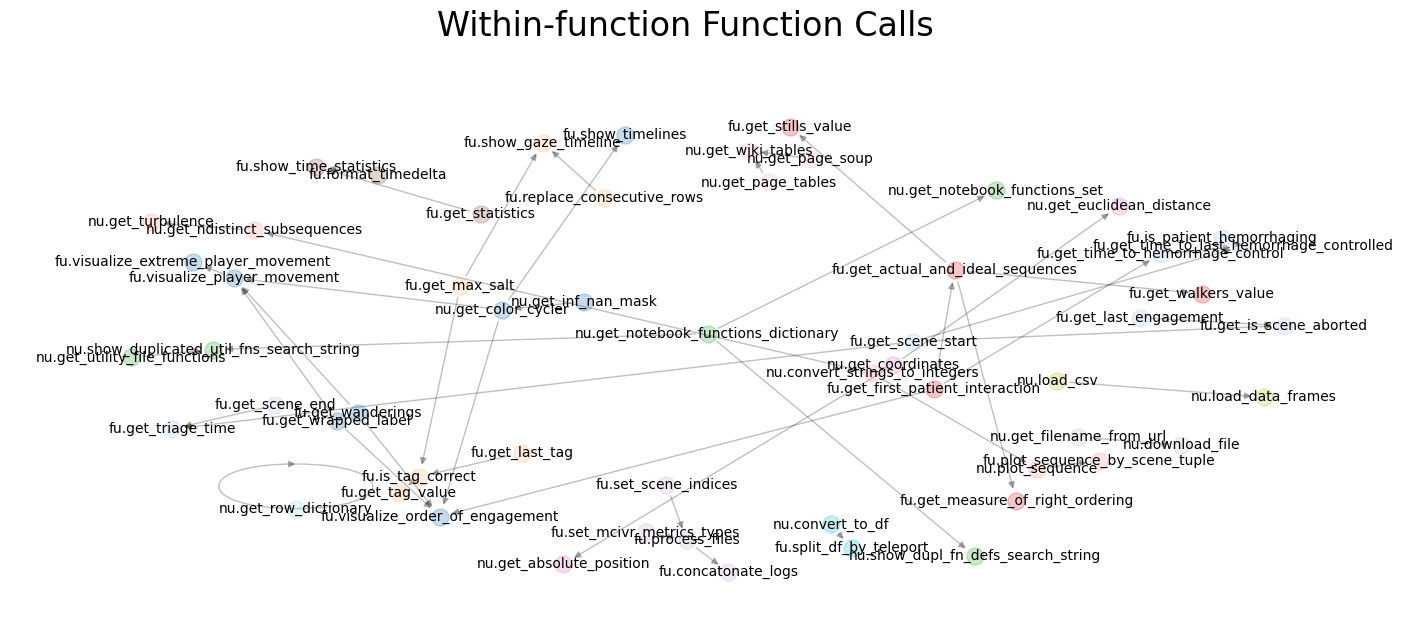

In [19]:

show_subgraph(dg, nodes_list_list=nodes_list_list, verbose=False)

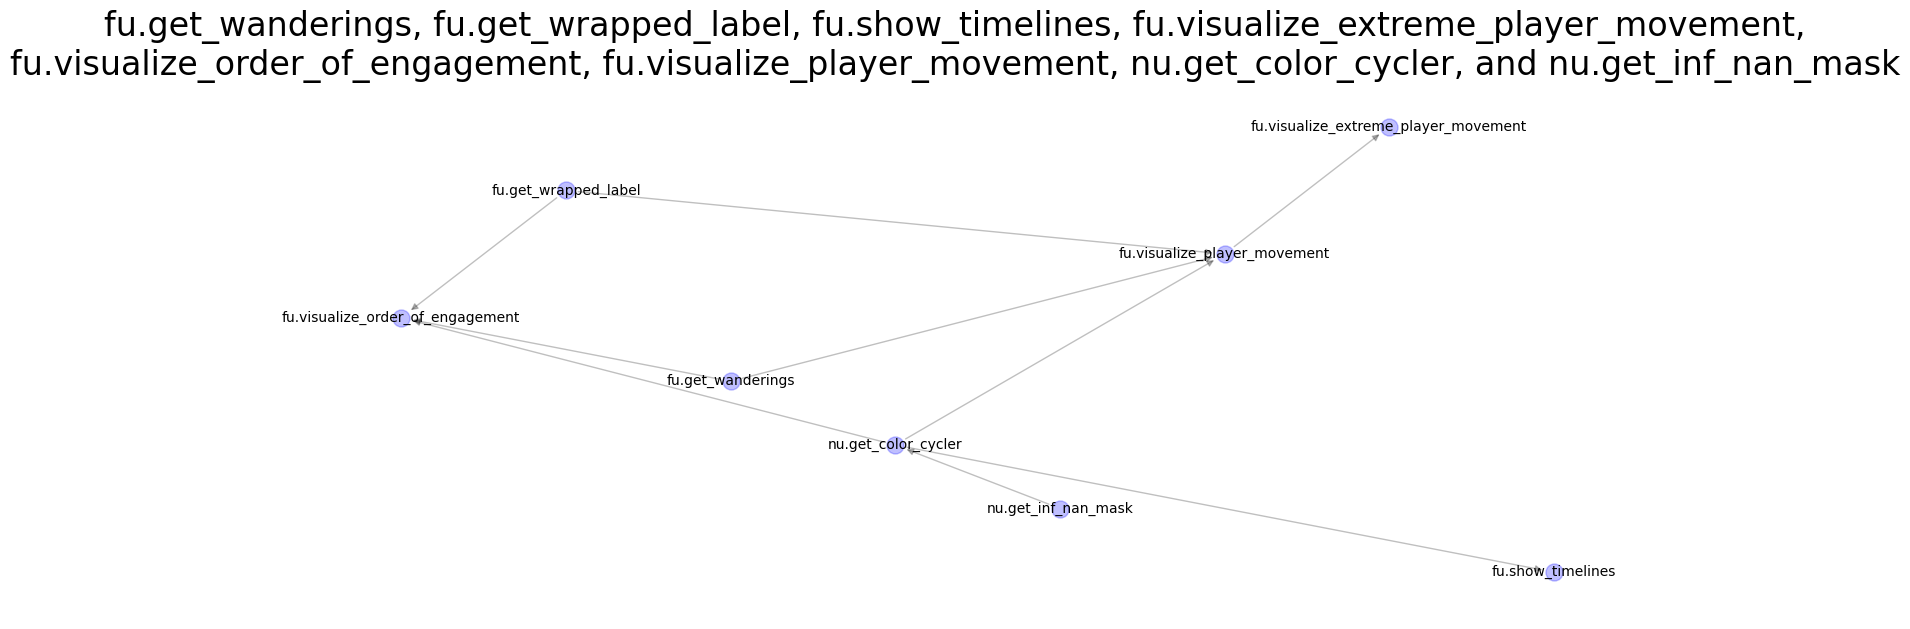

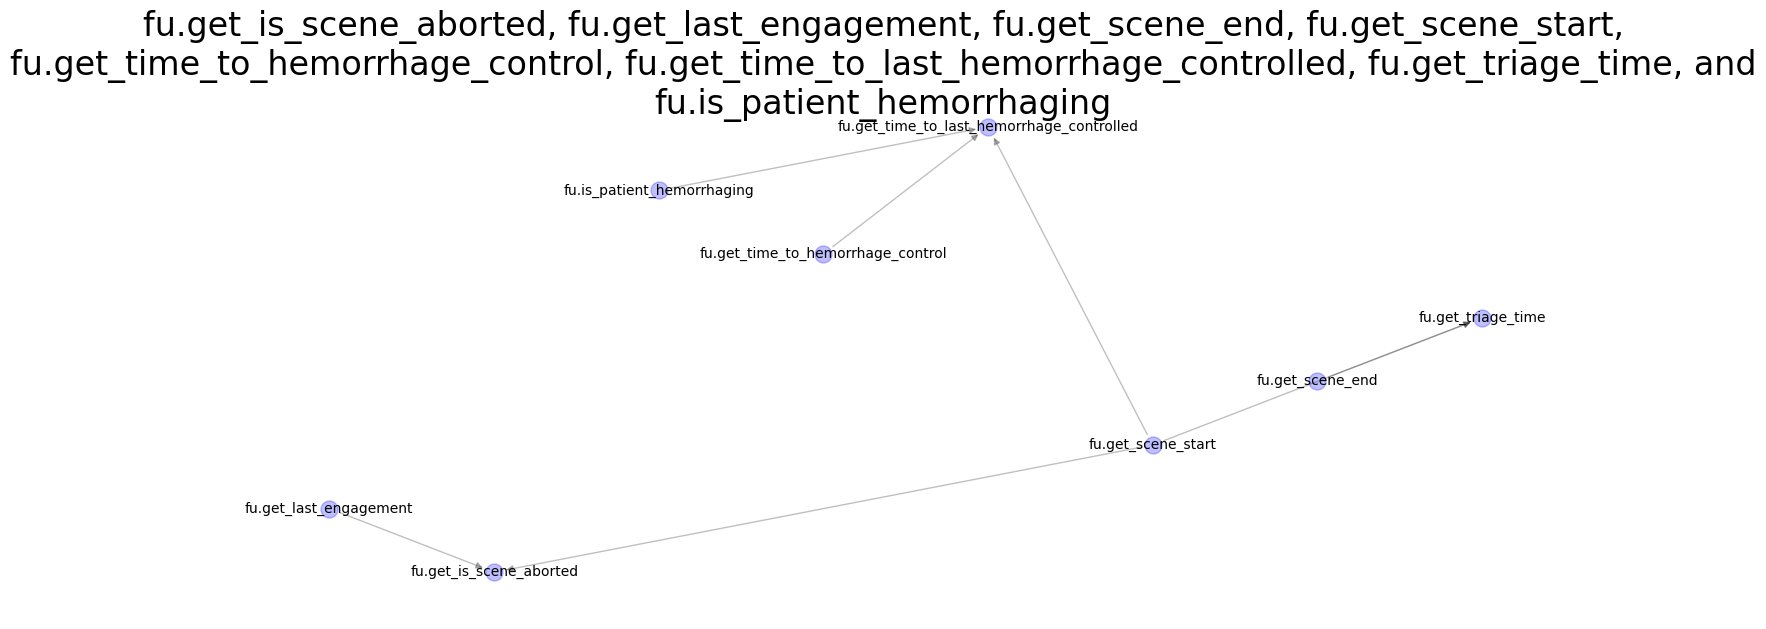

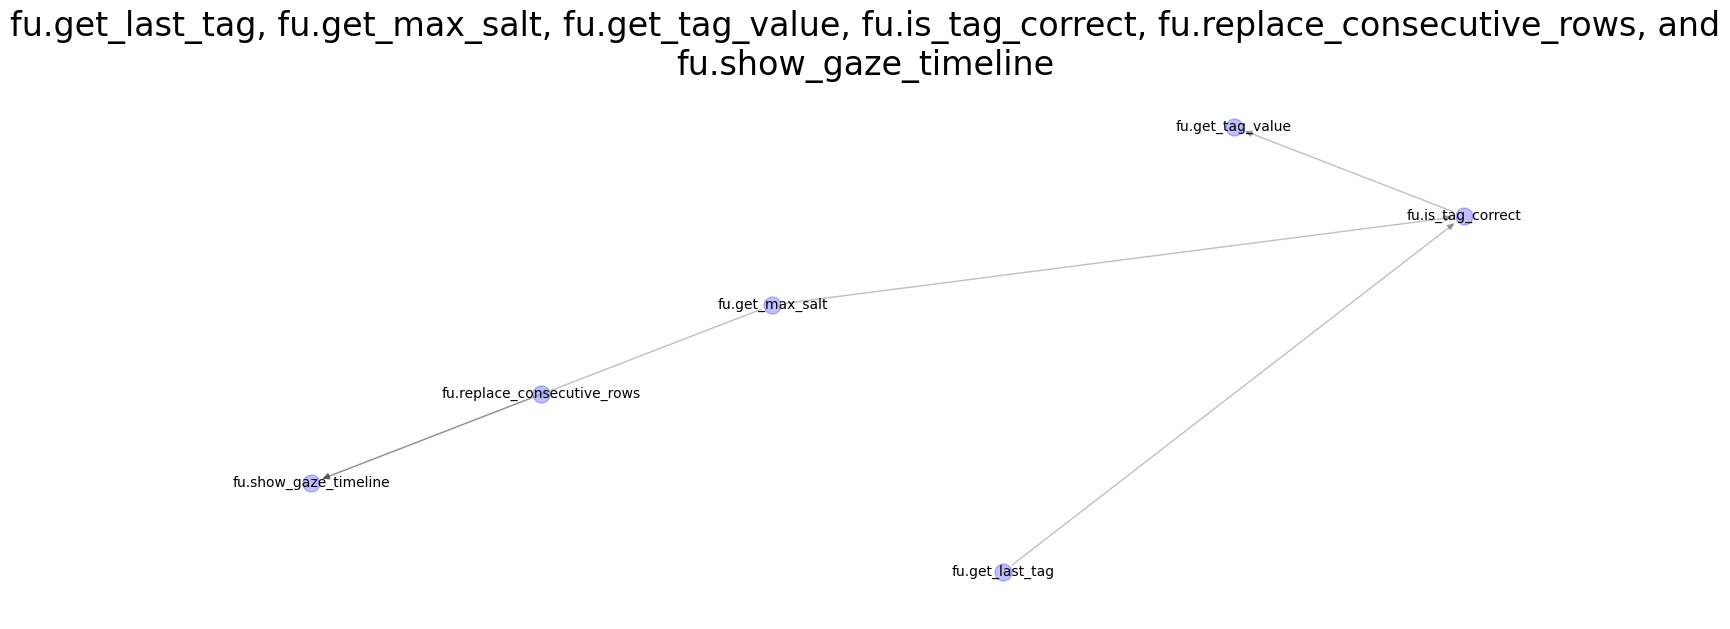

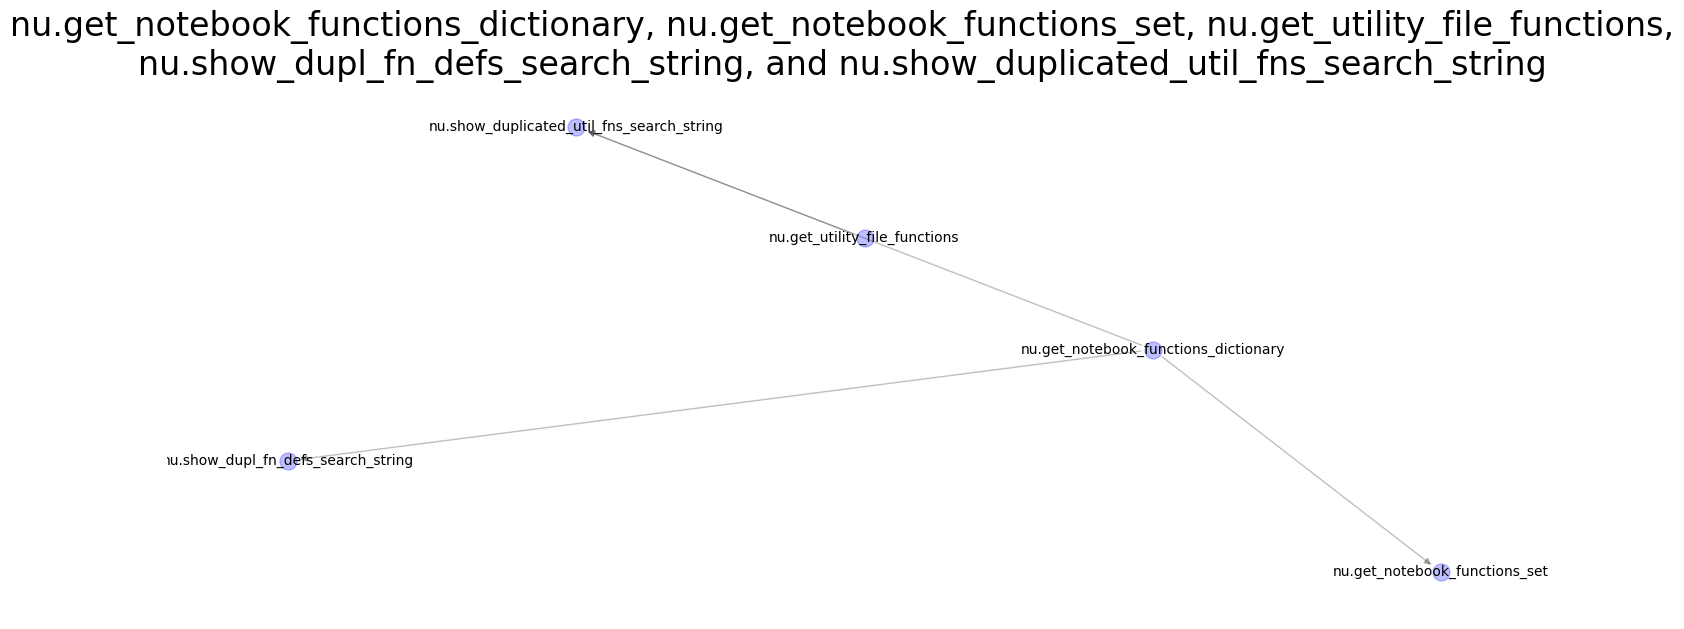

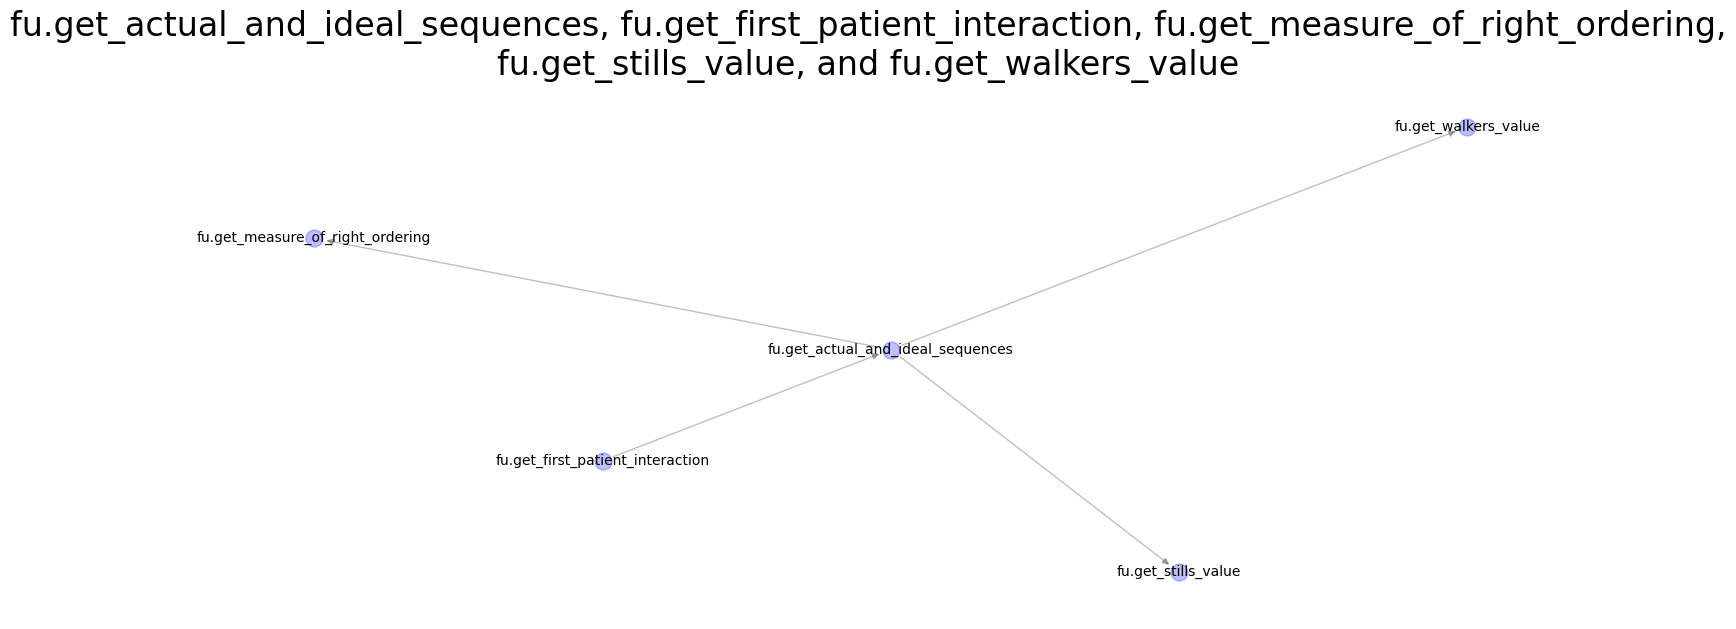

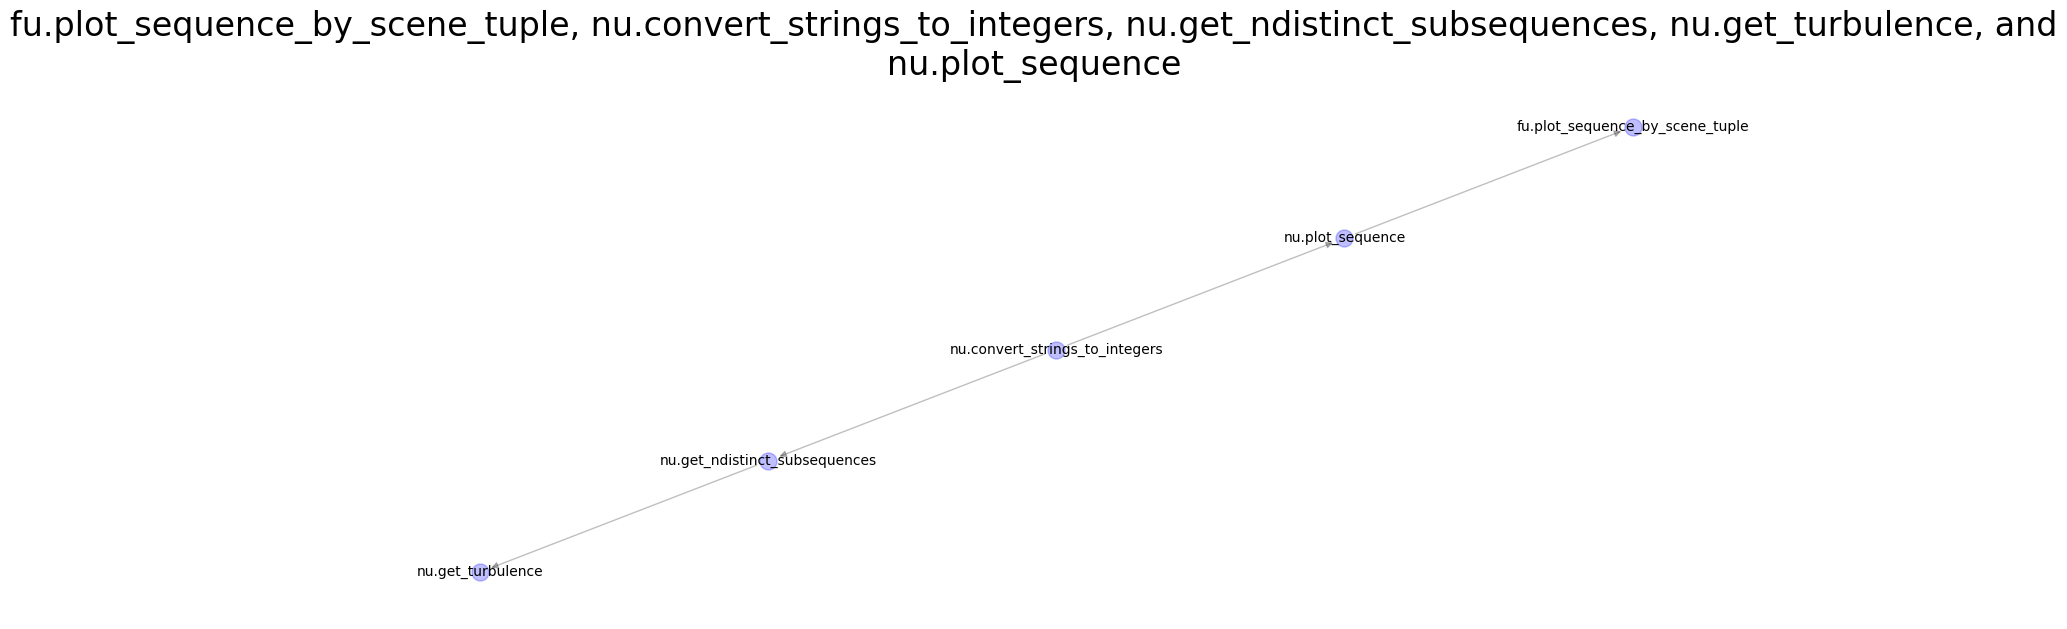

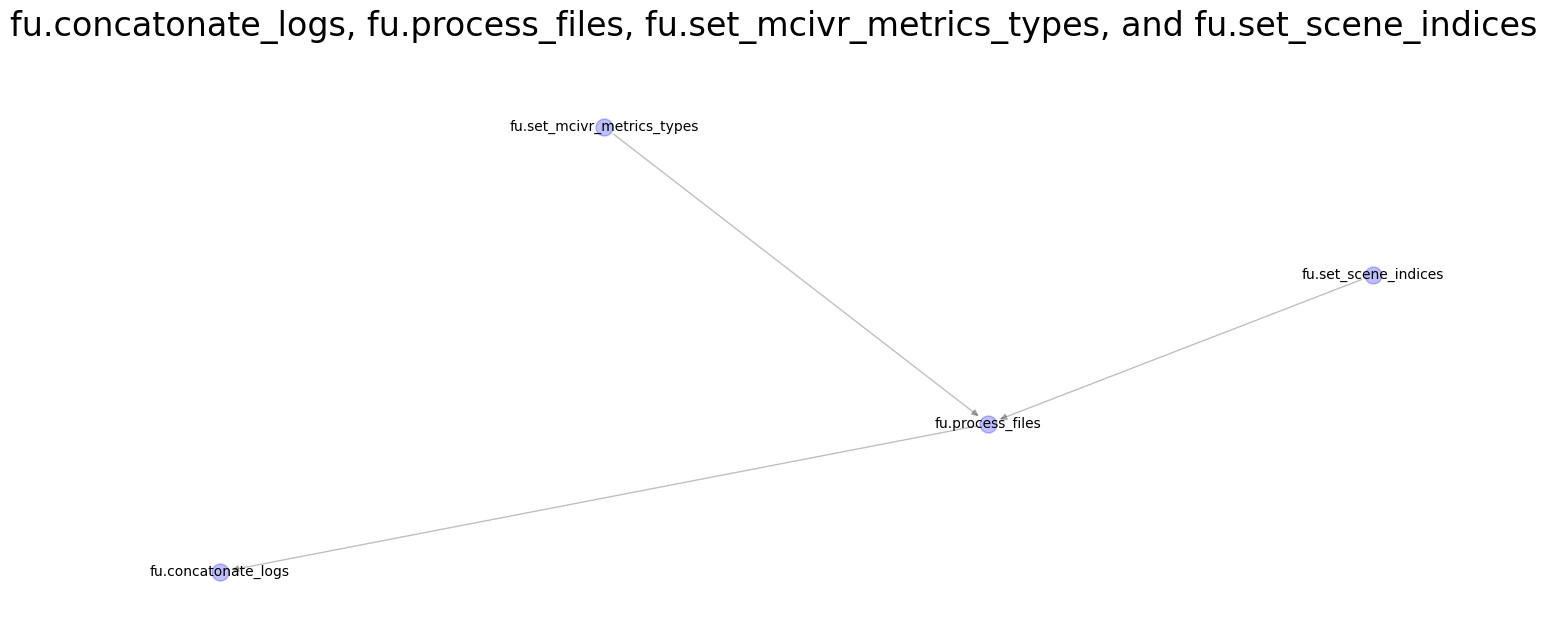

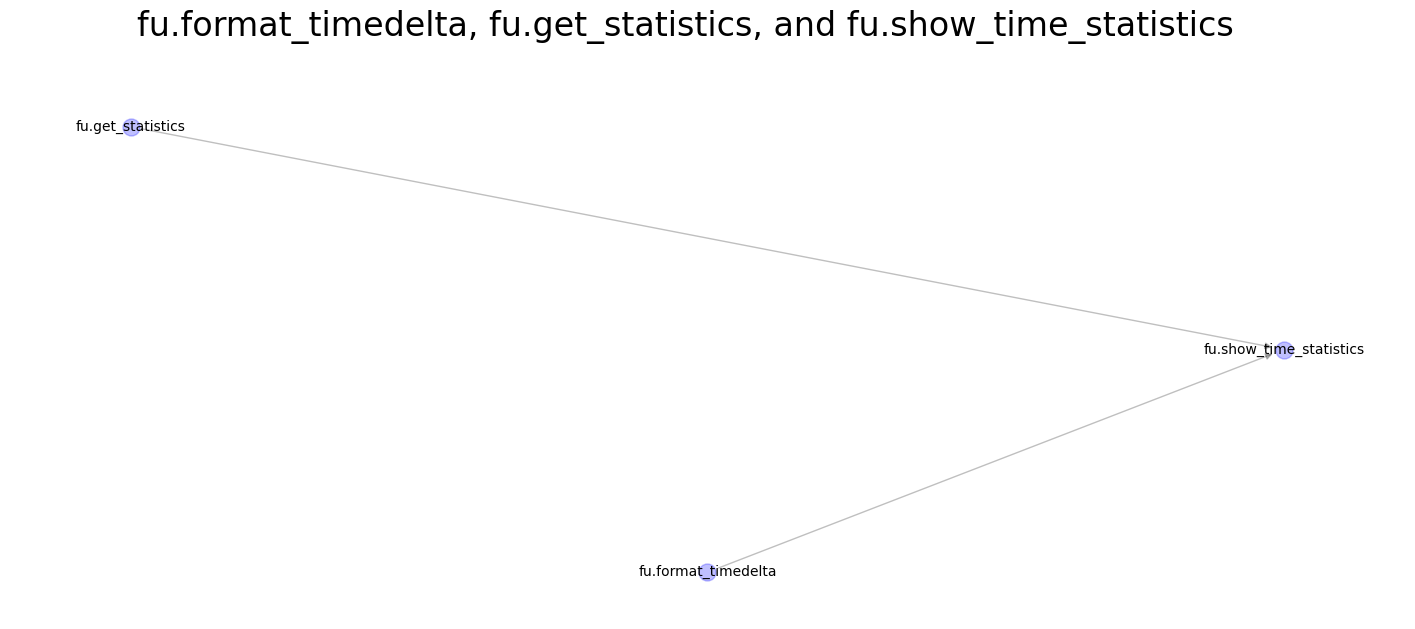

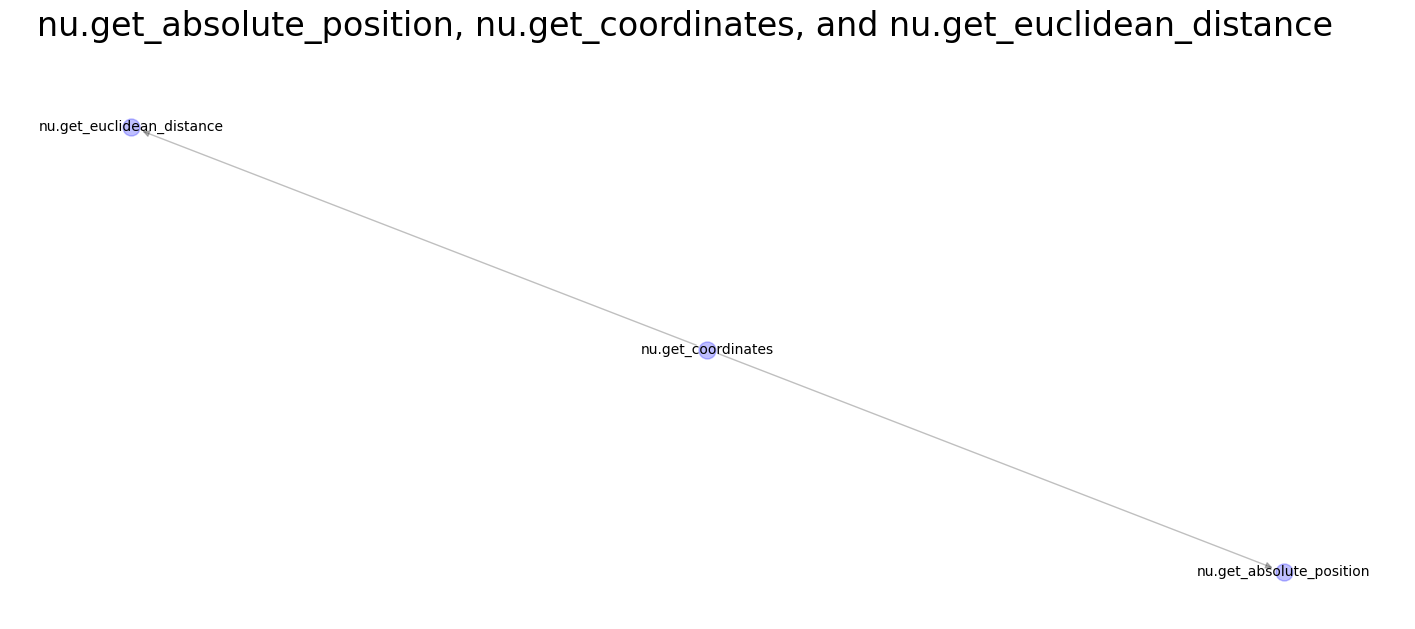

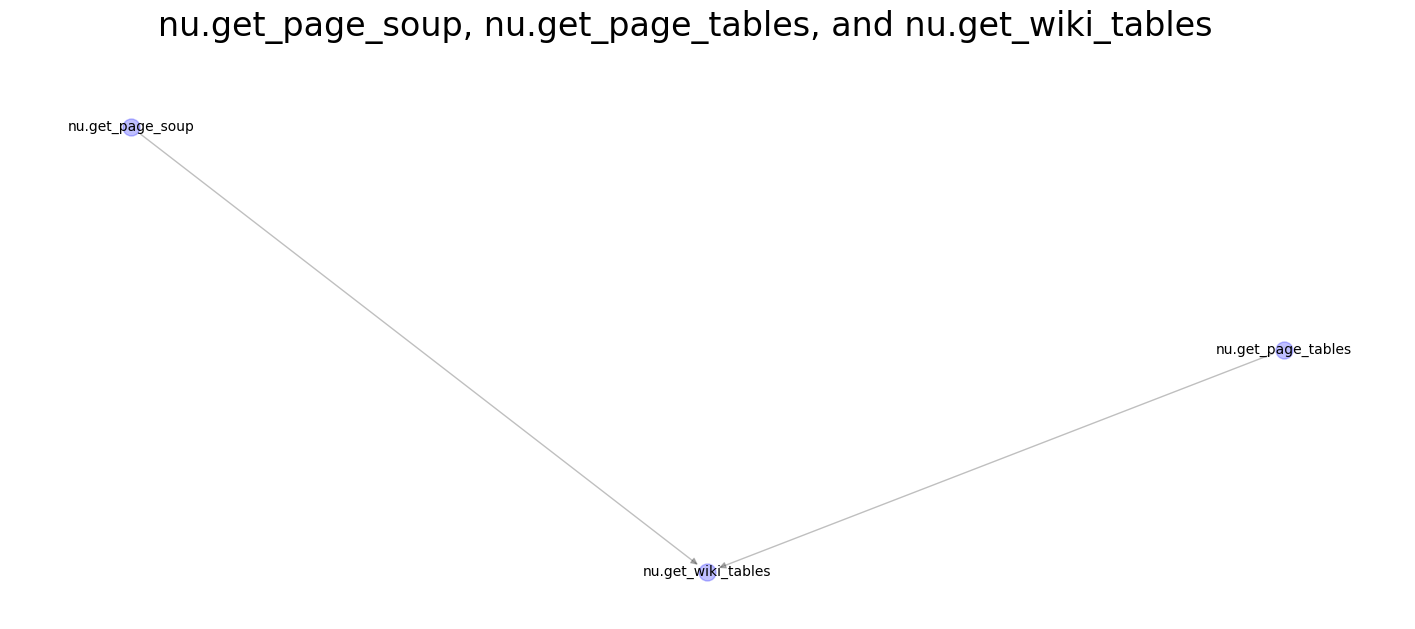

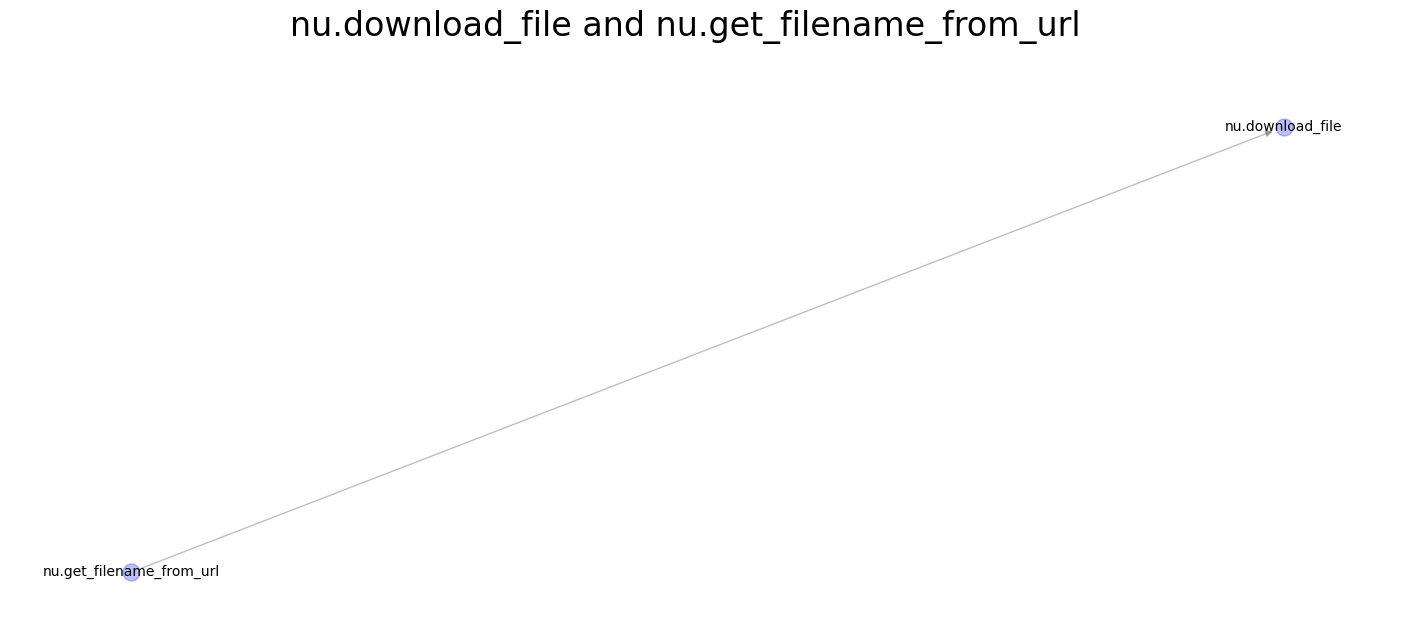

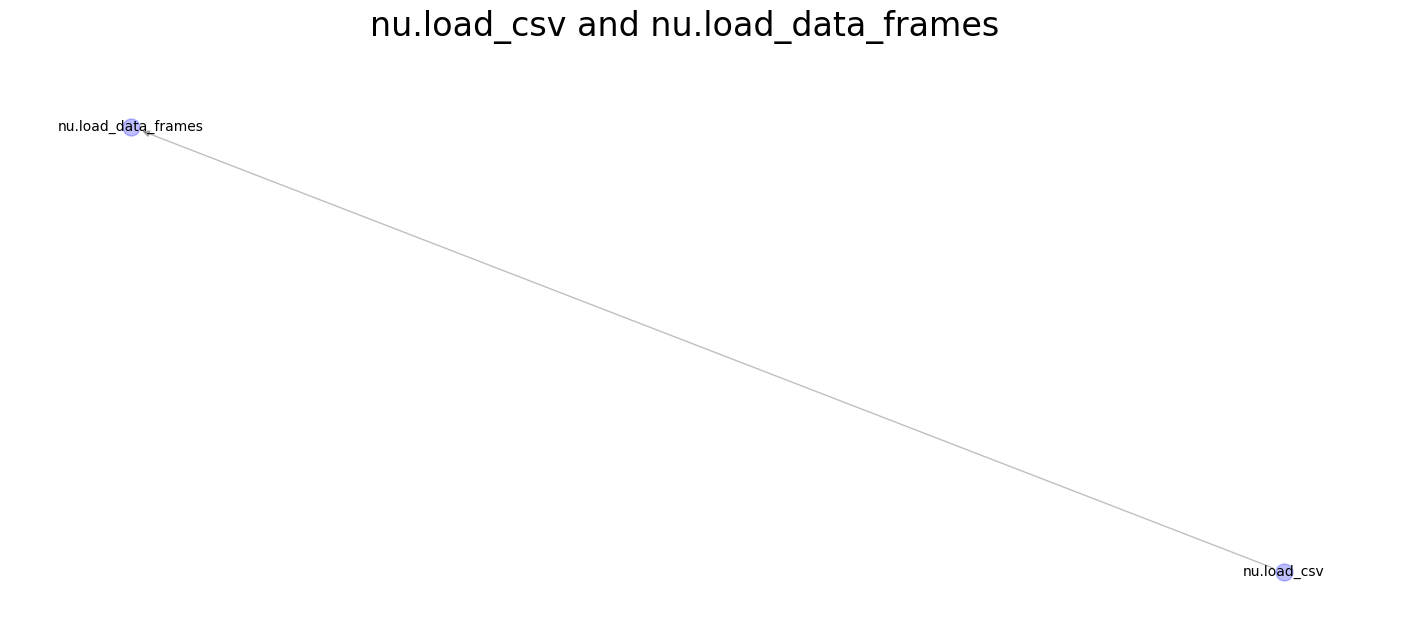

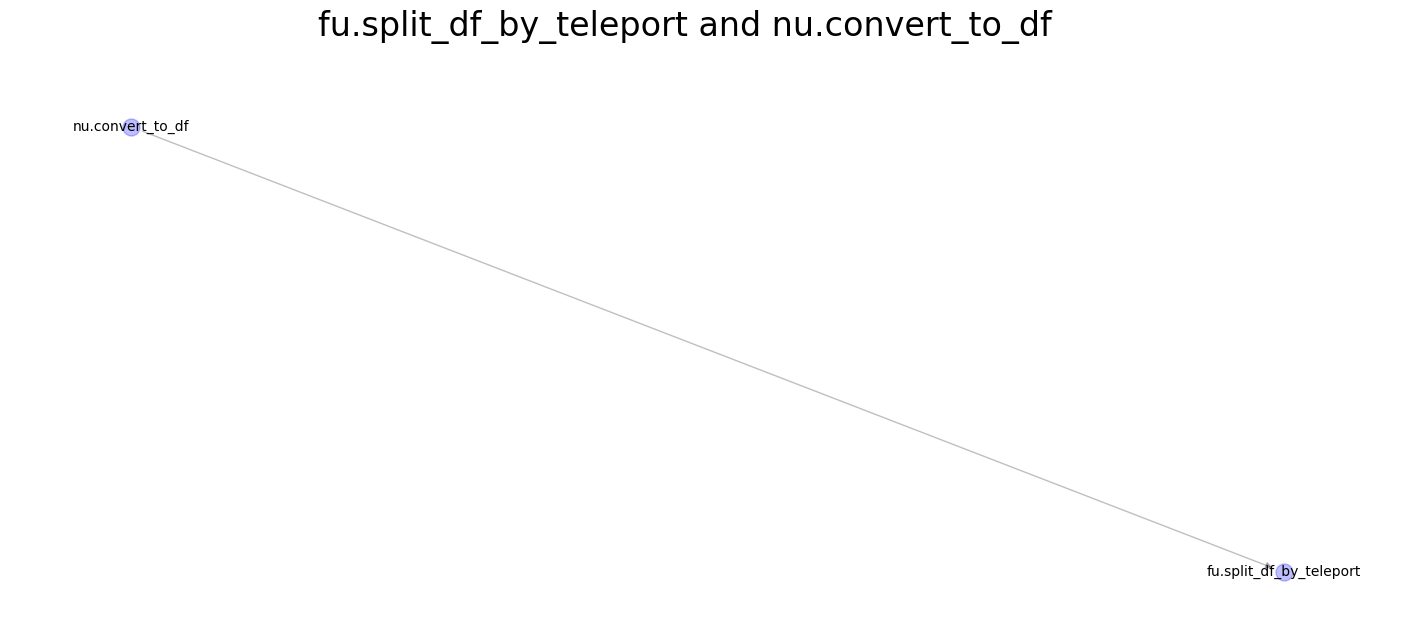

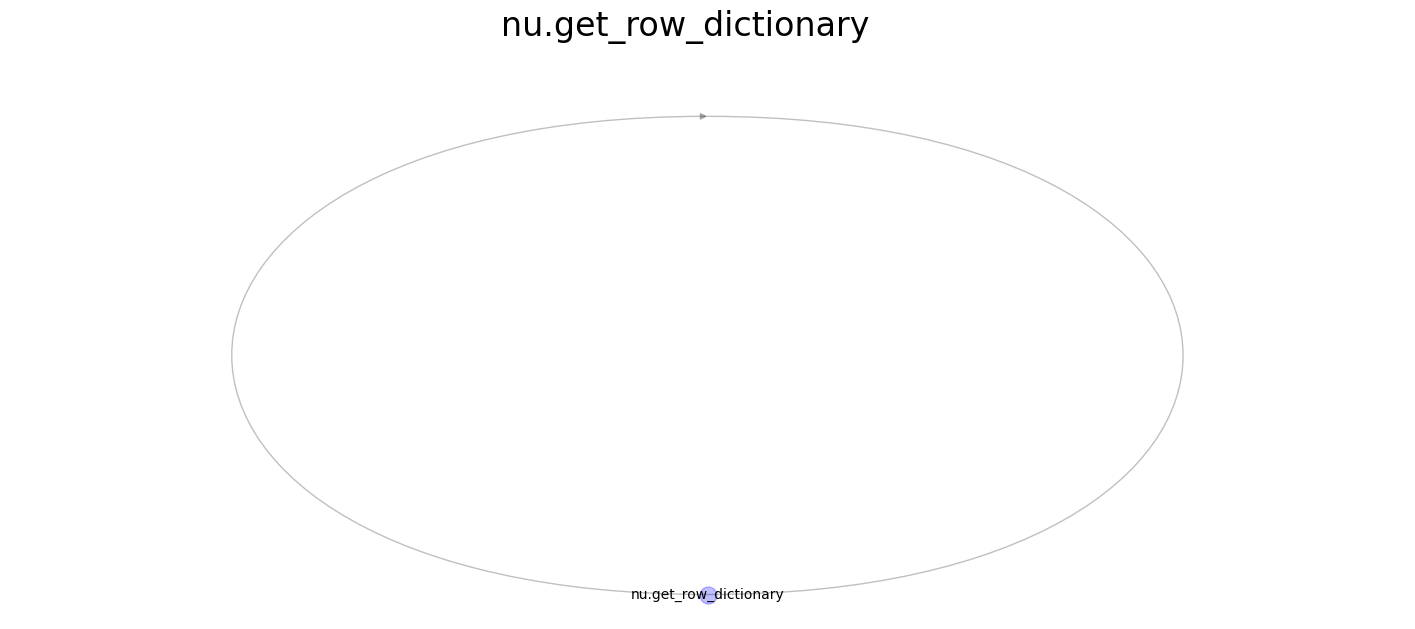

In [21]:

# Wrap the label to a specified width
import textwrap

for nodes_list in nodes_list_list:
    sub_graph = nx.subgraph(dg, nodes_list)
    suptitle = '\n'.join(textwrap.wrap(nu.conjunctify_nouns(nodes_list), width=120))
    show_subgraph(sub_graph, suptitle=suptitle)

In [67]:

[f'mpatches.ArrowStyle.{fn}' for fn in dir(mpatches.ArrowStyle) if not fn.startswith('_')]

['mpatches.ArrowStyle.BarAB', 'mpatches.ArrowStyle.BracketA', 'mpatches.ArrowStyle.BracketAB', 'mpatches.ArrowStyle.BracketB', 'mpatches.ArrowStyle.BracketCurve', 'mpatches.ArrowStyle.Curve', 'mpatches.ArrowStyle.CurveA', 'mpatches.ArrowStyle.CurveAB', 'mpatches.ArrowStyle.CurveB', 'mpatches.ArrowStyle.CurveBracket', 'mpatches.ArrowStyle.CurveFilledA', 'mpatches.ArrowStyle.CurveFilledAB', 'mpatches.ArrowStyle.CurveFilledB', 'mpatches.ArrowStyle.Fancy', 'mpatches.ArrowStyle.Simple', 'mpatches.ArrowStyle.Wedge', 'mpatches.ArrowStyle.get_styles', 'mpatches.ArrowStyle.pprint_styles', 'mpatches.ArrowStyle.register']

In [66]:

print(mpatches.ArrowStyle.pprint_styles())


    =============  ==========  ===============================================================================================================================
    Class          Name        Attrs                                                                                                                          
    =============  ==========  ===============================================================================================================================
    Curve          ``-``       None                                                                                                                           
    CurveA         ``<-``      head_length=0.4, head_width=0.2, widthA=1.0, widthB=1.0, lengthA=0.2, lengthB=0.2, angleA=0, angleB=0, scaleA=None, scaleB=None
    CurveB         ``->``      head_length=0.4, head_width=0.2, widthA=1.0, widthB=1.0, lengthA=0.2, lengthB=0.2, angleA=0, angleB=0, scaleA=None, scaleB=None
    CurveAB        ``<->``     head_length=0.


## List out various function calls

In [22]:

# Create a regular expression of all the non-staticmethod-decorated utils functions
instance_defs_regex = re.compile(r'^    def ([a-z]+[a-z_]+)\(\s*self,\s+(?:[^\)]+)\):', re.MULTILINE)
functions_list = []
for file_name in ['frvrs_utils.py', 'notebook_utils.py']:
    with open(f'../py/FRVRS/{file_name}', 'r', encoding=nu.encoding_type) as f: text = f.read()
    for match_obj in instance_defs_regex.finditer(text):
        functions_list.append(''.join([s[0] for s in file_name.split('.')[0].split('_')]) + '\\.' + match_obj.group(1))

instance_functions_regex = re.compile('\\b(' + '|'.join(functions_list) + ')\\b')

In [9]:

# Tabulate util function usage frequency
usage_frequency_dict = {}
all_calls_frequency_dict = {}
for sub_directory, directories_list, files_list in os.walk(nu.github_folder):
    if '.ipynb_checkpoints' not in sub_directory:
        for file_name in files_list:
            if file_name.endswith('.ipynb') and not ('Attic' in file_name):
                file_path = osp.join(sub_directory, file_name)
                with open(file_path, 'r', encoding=nu.encoding_type) as f:
                    lines_list = f.readlines()
                    for line in lines_list:
                        match_obj = instance_functions_regex.search(line)
                        if match_obj:
                            fn = match_obj.group(1)
                            usage_frequency_dict[fn] = usage_frequency_dict.get(fn, 0) + 1
                        match_obj = all_calls_regex.search(line)
                        if match_obj:
                            fn = match_obj.group()
                            all_calls_frequency_dict[fn] = all_calls_frequency_dict.get(fn, 0) + 1

In [10]:

usage_frequency_df = pd.Series(usage_frequency_dict).to_frame().reset_index().rename(columns={0: 'usage_frequency', 'index': 'function_call'})
usage_frequency_df.sort_values('usage_frequency', ascending=False).head(20)

,function_call,usage_frequency
11,fu.visualize_extreme_player_movement,36
4,fu.get_is_scene_aborted,25
5,nu.save_data_frames,20
13,nu.plot_sequence,17
25,fu.visualize_player_movement,15
12,fu.get_first_patient_interaction,14
26,fu.show_time_statistics,12
27,fu.plot_sequence_by_scene_tuple,10
17,nu.load_data_frames,9
21,nu.check_for_typos,8


In [11]:

all_calls_frequency_df = pd.Series(all_calls_frequency_dict).to_frame().reset_index().rename(columns={0: 'all_calls_frequency', 'index': 'function_call'})
all_calls_frequency_df.sort_values('all_calls_frequency', ascending=False).head(20)

,function_call,all_calls_frequency
14,fu.scene_groupby_columns,106
0,nu.pickle_exists,101
1,nu.load_object,101
3,nu.store_objects,85
2,fu.patient_groupby_columns,57
5,fu.get_session_groupby,39
44,fu.visualize_extreme_player_movement,36
20,nu.conjunctify_nouns,32
23,fu.get_logger_version,30
56,nu.get_sequences_by_count,27


In [ ]:

mask_series = (usage_frequency_df.usage_frequency == 1)
usage_frequency_df[mask_series]